In [7]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
#使用カラムを限定する
usecols=['Rooms', 'Type', 'Price', 'Method', 'SellerG',
        'Distance', 'Bedroom2', 'Bathroom', 'Car',
       'Landsize', 'BuildingArea', 'YearBuilt', 'Propertycount']
if not os.path.exists('Melbourne_housing_FULL.csv'):
    !wget "https://drive.google.com/uc?export=download&id=1Ow53Wl7g40Pr1ExUoJ4P-IrSejpzUalt" -O Melbourne_housing_FULL.csv

df=pd.read_csv("Melbourne_housing_FULL.csv",usecols=usecols)
df_origin = df

In [2]:
print(df.shape)
print(df.info())

(34857, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Rooms          34857 non-null  int64  
 1   Type           34857 non-null  object 
 2   Price          27247 non-null  float64
 3   Method         34857 non-null  object 
 4   SellerG        34857 non-null  object 
 5   Distance       34856 non-null  float64
 6   Bedroom2       26640 non-null  float64
 7   Bathroom       26631 non-null  float64
 8   Car            26129 non-null  float64
 9   Landsize       23047 non-null  float64
 10  BuildingArea   13742 non-null  float64
 11  YearBuilt      15551 non-null  float64
 12  Propertycount  34854 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 3.5+ MB
None


In [3]:
df.dropna(subset=['Price'], inplace=True)

In [4]:
import sklearn
print("全データ数")
print(len(df["Rooms"])) # Roomsに欠損がないことを知っているので
print("\n欠損数の確認")
print(df.isnull().sum())
#カテゴリ値を数値変換
le = preprocessing.LabelEncoder()
df[[ 'Type', 'Method', 'SellerG']]=df[[ 'Type', 'Method', 'SellerG']].apply(le.fit_transform)
df_train=df.drop("Price",axis=1)
df_label=df["Price"].values
print("\n訓練データの確認")
print(df_train)
print("\n訓練ラベルの確認(つまりお部屋のお値段、これを当てる)")
print(df_label)

全データ数
27247

欠損数の確認
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Distance             1
Bedroom2          6441
Bathroom          6447
Car               6824
Landsize          9265
BuildingArea     16591
YearBuilt        15163
Propertycount        3
dtype: int64

訓練データの確認
       Rooms  Type  Method  SellerG  Distance  Bedroom2  Bathroom  Car  \
1          2     0       1       32       2.5       2.0       1.0  1.0   
2          2     0       1       32       2.5       2.0       1.0  0.0   
4          3     0       3       32       2.5       3.0       2.0  0.0   
5          3     0       0       32       2.5       3.0       2.0  1.0   
6          4     0       4      206       2.5       3.0       1.0  2.0   
...      ...   ...     ...      ...       ...       ...       ...  ...   
34852      4     0       0      140       6.3       4.0       1.0  3.0   
34853      2     0       3      290       6.3       2.0       2.0 

In [5]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import copy
def run_model(df_train,df_label):
    params={
        'objective': 'regression',
        'random_state' : 1,
        "metric": "rmse",
        }
    kfold = 5
    score=0
    kf = KFold(n_splits=kfold,shuffle=True,random_state=94) #交差検証する関数を定義、データをkfold個にわけて1つをテスト用、残りを訓練に使う
    importance=0
    for i, (train_index, test_index) in enumerate(kf.split(df_train, df_label)): #定義したKFoldでdf_trainとdf_labelを分割
        print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[test_index] #train_indexなどは「選択した要素の配列」0から要素数あり、kfoldの確率で抜けている
        y_train, y_valid = df_label[train_index], df_label[test_index] #上と同様だが、要素が一つしかないのでこれでよい
        dtrain = lgb.Dataset(X_train, label=y_train) #まとめてデータセットを構成する
        dvalid = lgb.Dataset(X_valid, label=y_valid)
        bst = lgb.train(params, dtrain, num_boost_round=1000,valid_sets=[dtrain, dvalid])
        # LightGBMで学習、1000回試行して、ベストなものを返す
        importance += pd.DataFrame(bst.feature_importance(), index=df_train.columns, columns=['importance'])
        score+=bst.best_score["valid_1"]['rmse']
    return importance,score/5

In [14]:
imp,score = run_model(df_train,df_label)
print(score)
print(imp)
scored = score

[Fold 1/5]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1042830.453962
[Fold 2/5]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000554 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1286
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1050089.052255
[Fold 3/5]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002297 seconds.
You can set `force_col_wise=tr

In [15]:
#欠損値を補完関数IterativeImputerのデフォルトのBaysian Ridgeで補完
imp = IterativeImputer(max_iter=50, random_state=5) # 方法の定義
df_train_fi = pd.DataFrame(imp.fit_transform(df_train)) # 定義した方法を用いて実際に補完
df_train_fi.columns = df_train.columns # カラム情報もコピーしておく
imp,score = run_model(df_train_fi,df_label)
print(score)
scorei = score

[Fold 1/5]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2146
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1042830.453962
[Fold 2/5]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2149
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1050089.052255
[Fold 3/5]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002553 seconds.
You can set `force_col_wise=tr

In [16]:
#欠損値を補完関数IterativeImputerのKNeighborsRegressorで補完
from sklearn.neighbors import KNeighborsRegressor
imp = IterativeImputer(estimator=KNeighborsRegressor(n_neighbors=15),max_iter=10,random_state=0)
df_train_fk = pd.DataFrame(imp.fit_transform(df_train))
df_train_fk.columns = df_train.columns
imp,score = run_model(df_train_fk,df_label)
print(score)
scorek = score

/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


[Fold 1/5]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1508
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1042830.453962
[Fold 2/5]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1513
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1050089.052255
[Fold 3/5]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 21798, n

In [9]:
import missingno as msno

In [17]:
print("結果")
print("何もしない", scored)
print("Baysian Ridge", scorei)
print("KNeighborsRegressor", scorek)

結果
何もしない 300266.36862001906
Baysian Ridge 307807.8609853602
KNeighborsRegressor 309621.75748651166


In [18]:
#pandasで補完
dfp = df_train.interpolate(limit_direction='both')
df_train_fp=pd.DataFrame(dfp)
df_train_fp.columns=df_train.columns
imp,score=run_model(df_train_fp,df_label)
print(score)
scorep = score

[Fold 1/5]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1042830.453962
[Fold 2/5]
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1852
[LightGBM] [Info] Number of data points in the train set: 21797, number of used features: 12
[LightGBM] [Info] Start training from score 1050089.052255
[Fold 3/5]
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can

In [19]:
print("結果")
print("何もしない", scored)
print("Baysian Ridge", scorei)
print("KNeighborsRegressor", scorek)
print("Pandasで補完", scorep)

結果
何もしない 300266.36862001906
Baysian Ridge 307807.8609853602
KNeighborsRegressor 309621.75748651166
Pandasで補完 318582.4338602943


<Axes: >

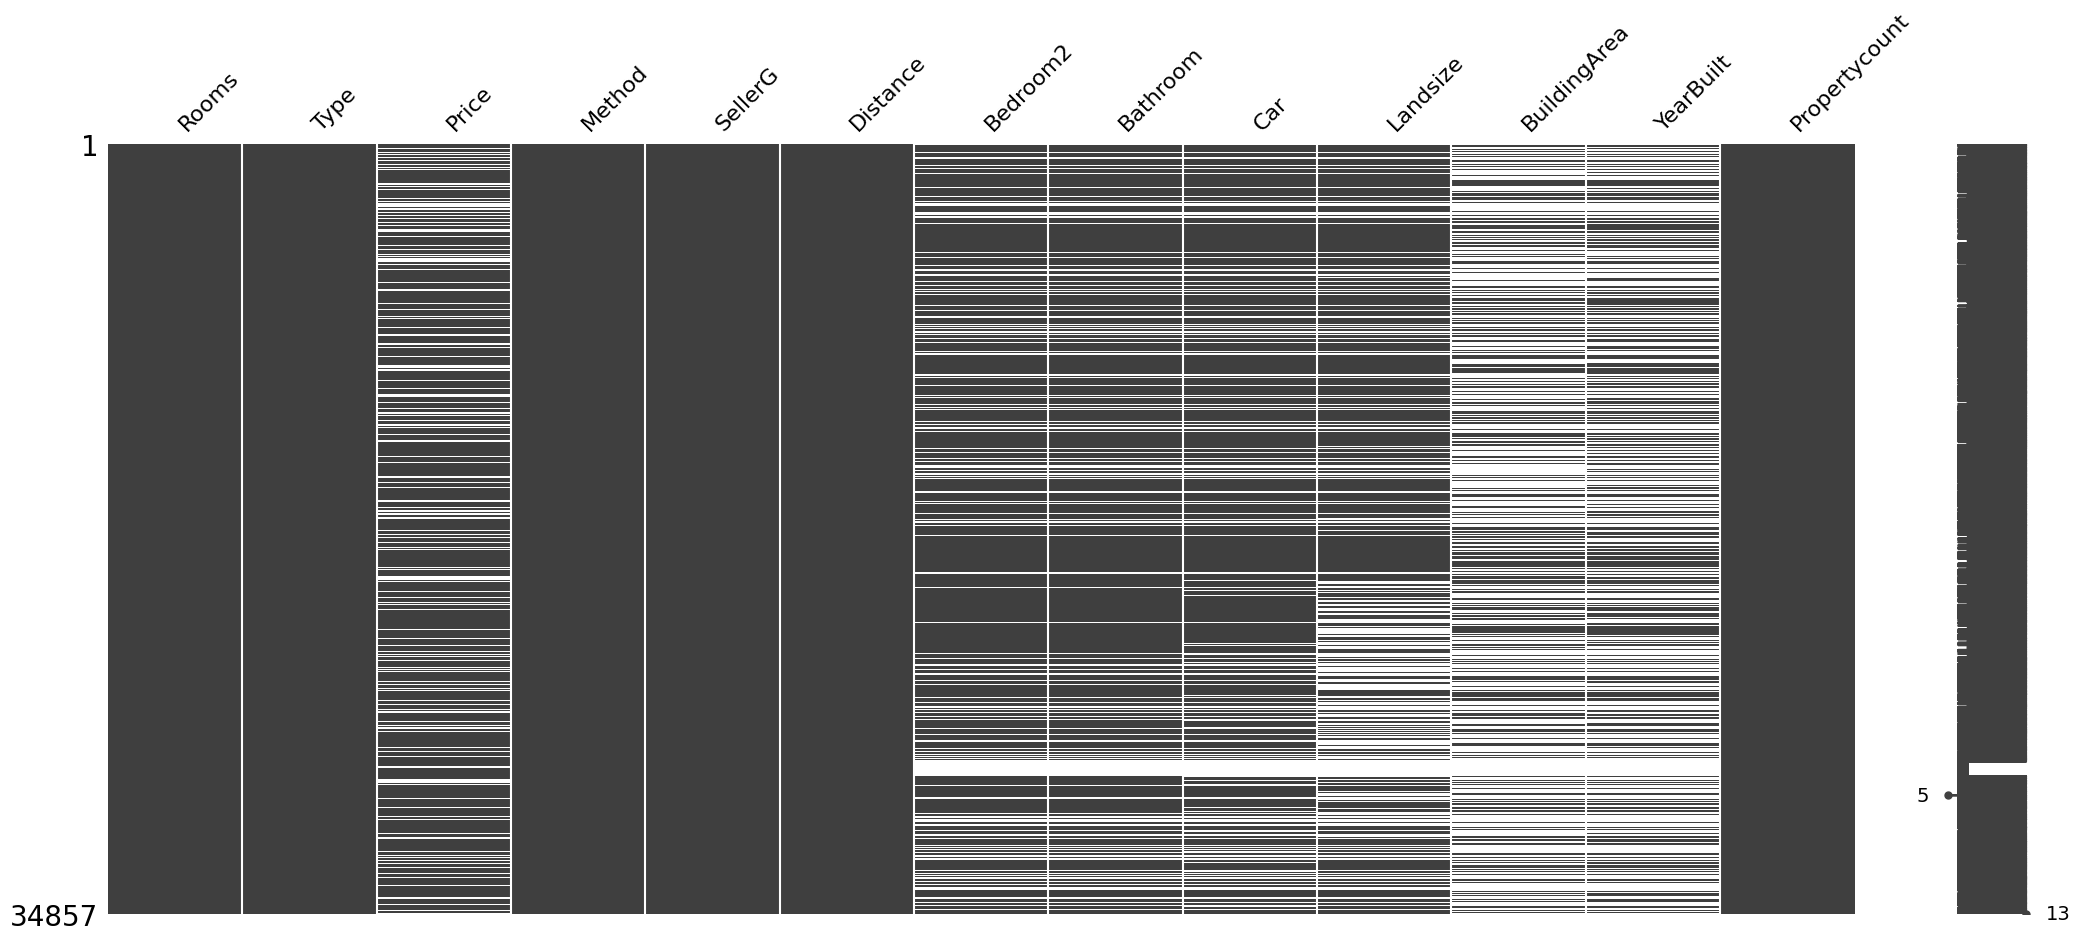

In [10]:
msno.matrix(df_origin)

<Axes: >

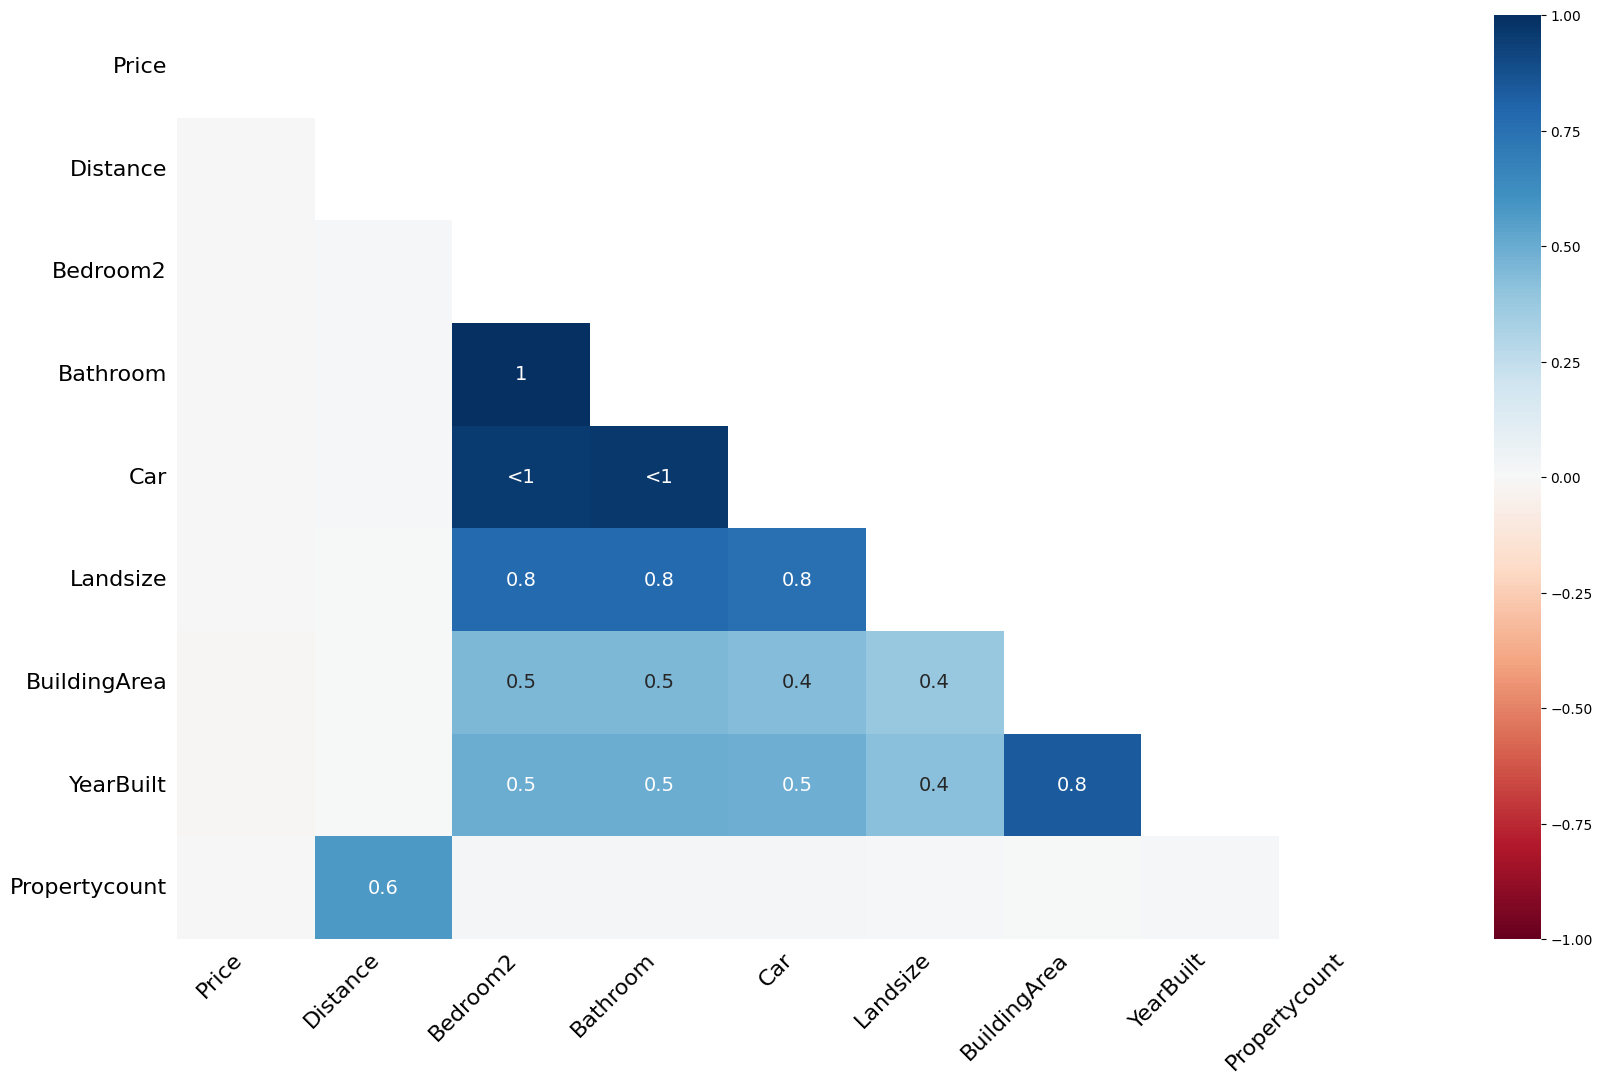

In [11]:
msno.heatmap(df_origin)

授業動画で言ってたやつ。欠損にも意味がある。
補間アルゴリズムはRidge回帰、KNeighborでいいのか問題  
今回のデータセットの中では欠損のおおい BuildingArea, YearBuiltが重要な説明変数の可能性がある。